# (10) Reservoir + GLM
**Motivation**: Very competetive models with Resrvoir + GLM. This notebook: ```expt=clu090```.

## Approach:
1. STA
2. find best_lag
3. at best_lag, find best $(i, j)$
4. Additionally, you can find best filters as well.
5. Finally, fit a GLM at best-lag and best $(i, j)$ using all or a subset of filters.
<br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from torch.nn import functional as F
from sklearn.decomposition import PCA

from analysis.glm import prepare_data, extract_features
from analysis.linear import LinearModel, flatten_stim, compute_sta
from base.dataset import setup_supervised_data, setup_repeat_data, time_embed

## Create reservoir

In [3]:
vae = VAE(ConfigVAE('fixate1_dim-65_n-10k', ker_sz=4, input_sz=19))
tr = TrainerVAE(vae, ConfigTrainVAE(batch_size=500), device='cuda')
vae.print()
print(vae.cfg.name())
vae.scales, vae.cfg.total_latents()

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  17.0 Mil  |
|     ---      |    ---     |
|     stem     |   1.1 K    |
| pre_process  |   96.0 K   |
|  enc_tower   |  9.4 Mil   |
|     enc0     |   16.6 K   |
| enc_sampler  |  1.4 Mil   |
| dec_sampler  |  1.4 Mil   |
|    expand    |   71.0 K   |
|  dec_tower   |  4.5 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

k-32_z-7x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)

([8, 4], 210)

## Load neuron

In [4]:
expt = 'clu090'
kws_hf = dict(size=19, sres=1, radius=6)
stim, spks, good, stim_r, spks_r, good_r = prepare_data(
    expt=expt, tr=tr, kws_hf=kws_hf, rescale=2.25)
stim.shape, stim_r.shape

((72000, 2, 19, 19), (613, 2, 19, 19))

## Extract ftrs

In [5]:
kws_process = dict(scale=4, pool='max', act_fn='swish')
enc, enc_r = extract_features(tr, stim, stim_r, kws_process)
enc.shape, enc_r.shape

100%|█████████████████████████████████████████| 360/360 [01:31<00:00,  3.93it/s]


((72000, 5312, 4, 4), (613, 5312, 4, 4))

In [6]:
mu, sd = enc.mean(), enc.std()

enc_r = (enc_r - mu) / sd
enc = (enc - mu) / sd

print(f"(before) - - - \t mu: {mu}, sd: {sd}")

(before) - - -   mu: 0.0299233365803957, sd: 0.10497088730335236

In [7]:
# was use_ema=True, and float32

(before) - - -   mu: 0.026397444307804108, sd: 0.12137231230735779

In [6]:
# was use_ema=True, and float

(before) - - -   mu: 0.026398077516967346, sd: 0.12137023252225511

In [6]:
# was use_ema=False

(before) - - -   mu: 0.029923408880239543, sd: 0.1049725525820159

## STA

In [7]:
lags = 19
sta = compute_sta(
    lags=lags,
    good=good,
    stim=enc,
    spks=spks,
    zscore=True,
    verbose=True,
)
sta.shape

100%|████████████████████████████████████| 54386/54386 [04:58<00:00, 182.12it/s]


(1, 20, 5312, 4, 4)

In [8]:
sta.mean(), sta.std()

(0.013820175577658455, 0.09660381682004616)

In [9]:
dims = (2, 3, 4)
norm = np.mean(sta ** 2, axis=dims)
best_lag = np.argmax(norm[:, ::-1], axis=1)
norm.shape

(1, 20)

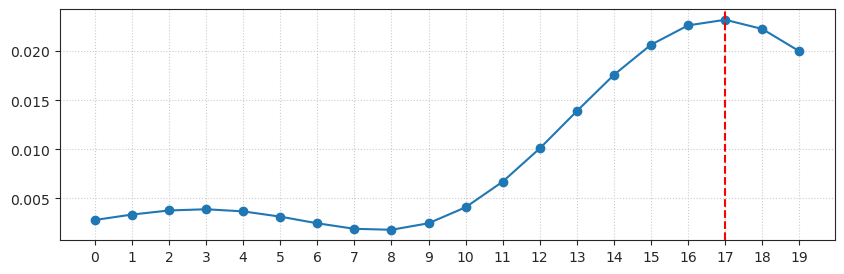

In [10]:
fig, ax = create_figure(1, 1, (10, 3))
ax.plot(norm[0], marker='o')
plt.axvline(lags - best_lag[0], color='r', ls='--')
ax.locator_params(axis='x', nbins=lags * 1.2)
ax.grid()

In [11]:
best_lag

array([2])

In [12]:
dims = (1, 2)
norm = sta[0][best_lag[0]]
norm = np.mean(norm ** 2, axis=dims)

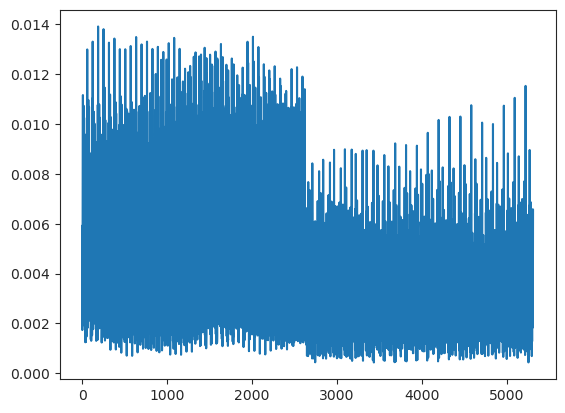

In [13]:
plt.plot(norm);

In [14]:
best_filts = np.argsort(norm)[::-1]
best_filts[0]

188

In [14]:
# was use_ema=True, and float

232

In [15]:
dims = (0,)
norm = sta[0][best_lag[0]]
norm = np.mean(norm ** 2, axis=dims)
best_i, best_j = np.unravel_index(np.argmax(norm), norm.shape)
best_i, best_j

(2, 3)

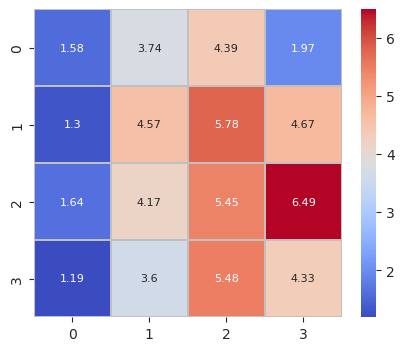

In [16]:
show_heatmap(norm * 1000, cmap='coolwarm', vmin=None, vmax=None, fmt='1.3g', figsize=(5, 4));

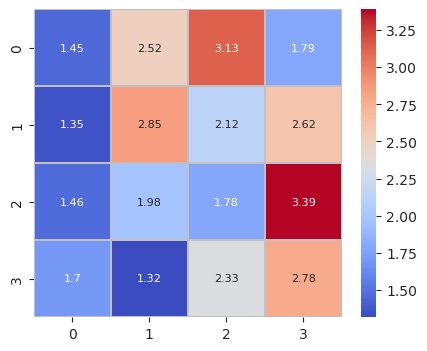

In [16]:
# was use_ema=True, and float

In [17]:
neuron_i = 0

idxs = good.copy()
idxs = idxs[idxs > best_lag[neuron_i]]

x = enc[idxs - best_lag[0], :, best_i, best_j]
x_r = enc_r[good_r - best_lag[0], :, best_i, best_j]

mu = x.mean(0, keepdims=True)
sd = x.std(0, keepdims=True)

x = (x - mu) / sd
x_r = (x_r - mu) / sd

x.shape, x_r.shape

((54386, 5312), (200, 5312))

In [34]:
%%time

top_n = 2000

glm_kws = dict(
    category='PoissonRegressor',
    x=x[:, best_filts[:top_n]],
    y=spks[idxs, neuron_i],
    x_tst=x_r[:, best_filts[:top_n]],
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[0.01, 0.1, 1],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=100)
print(glm.r2_tst)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


{0.01: 67.81078848789481, 0.1: 66.03015024484039, 1: 56.72751291463764}

CPU times: user 10min 30s, sys: 54.4 s, total: 11min 24s
Wall time: 3min 16s


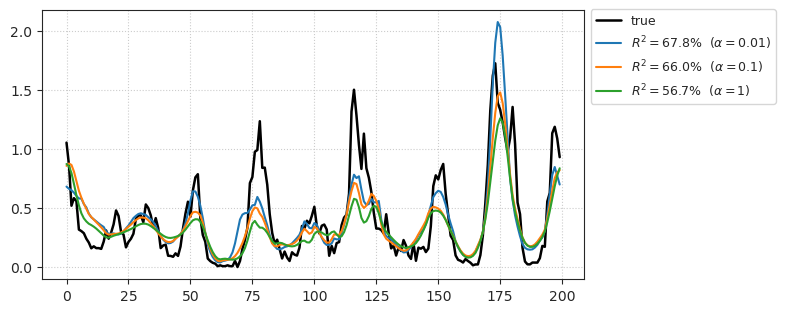

In [35]:
glm.show_pred();

In [36]:
%%time

glm_kws = dict(
    category='PoissonRegressor',
    x=x,
    y=spks[idxs, neuron_i],
    x_tst=x_r,
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[0.01, 0.1, 1],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=100)
print(glm.r2_tst)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


{0.01: 61.91076973308524, 0.1: 67.39435265392588, 1: 65.15033758386559}

CPU times: user 23min 31s, sys: 3min 4s, total: 26min 35s
Wall time: 6min 2s


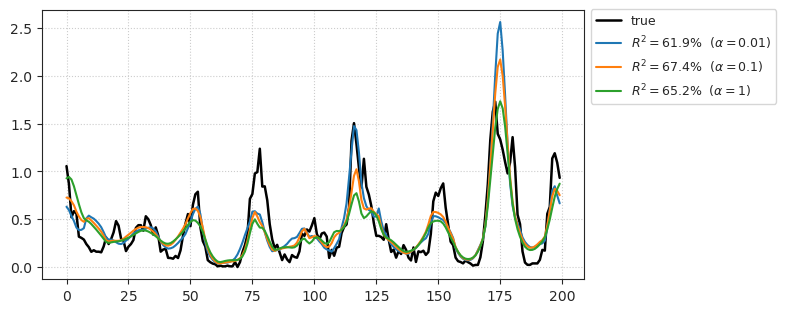

In [37]:
glm.show_pred();

In [39]:
c = glm.models[0.1].coef_

In [40]:
c.shape

(5312,)

In [44]:
u, s, v = sp_lin.svd(sta[0, ..., best_i, best_j])

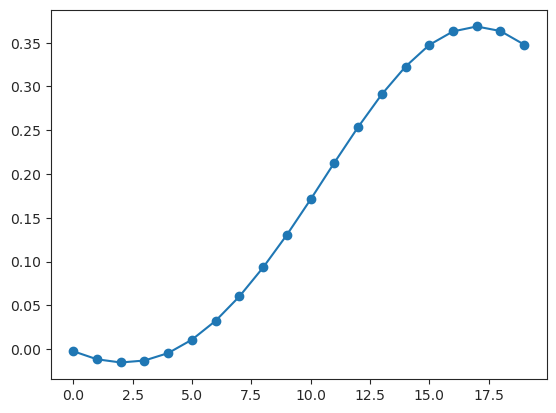

In [47]:
plt.plot(u[:, 0], marker='o')

In [50]:
sp_stats.pearsonr(c, v[0])

(0.15788671850852828, 5.370692816528103e-31)

In [68]:
test = sk_linear.PoissonRegressor(alpha=0.1, warm_start=True)
test.coef_ = v[0] / 10
test.intercept_ = 0

In [69]:
test.fit(x, spks[idxs, neuron_i])
pred = test.predict(x_r)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


In [70]:
sk_metric.r2_score(glm_kws['y_tst'], pred) * 100

68.66322806846182

## Fit using 10 lags

In [78]:
dims = (1, 2)
norm = np.mean(sta ** 2, axis=dims)
best_i, best_j = np.unravel_index(np.argmax(norm[0]), norm[0].shape)
best_i, best_j

(1, 2)

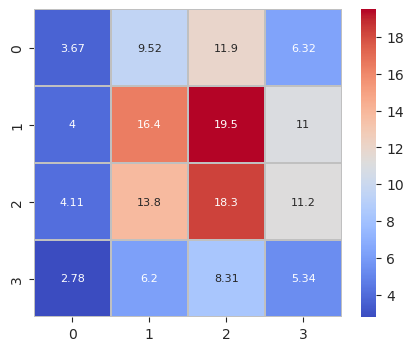

In [79]:
show_heatmap(norm[0] * 1000, cmap='coolwarm', vmin=None, vmax=None, fmt='1.3g', figsize=(5, 4));

In [81]:
src = time_embed(enc[..., best_i, best_j], lags=12, idxs=good)
src_r = time_embed(enc_r[..., best_i, best_j], lags=12, idxs=good_r)

mu = src.mean(0, keepdims=True)
sd = src_r.std(0, keepdims=True)

src = (src - mu) / sd
src_r = (src_r - mu) / sd

src.shape, src_r.shape

((54386, 12, 5312), (200, 12, 5312))

In [82]:
%%time

glm_kws = dict(
    category='PoissonRegressor',
    x=src,
    y=spks[idxs, neuron_i],
    x_tst=src_r,
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[0.01, 0.1, 1],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=50)
print(glm.r2_tst)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

{0.01: 50.01689322998719, 0.1: 57.019483255533984, 1: 58.608831254233976}

CPU times: user 2h 6min 45s, sys: 18min 27s, total: 2h 25min 13s
Wall time: 35min 19s


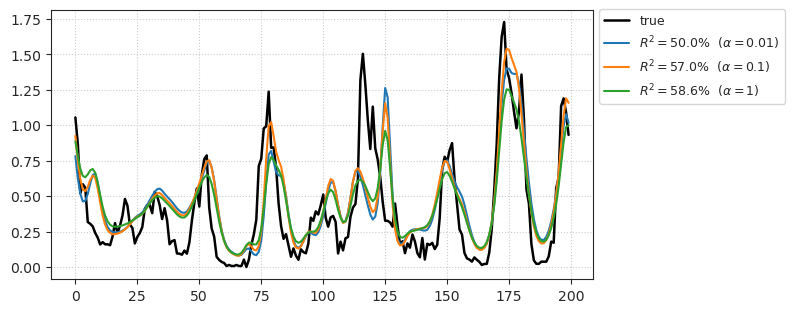

In [83]:
glm.show_pred();

## loop

In [84]:
dims = (0,)
norm = sta[0][best_lag[0]]
norm = np.mean(norm ** 2, axis=dims)
best_i, best_j = np.unravel_index(np.argmax(norm), norm.shape)
best_i, best_j

(2, 3)

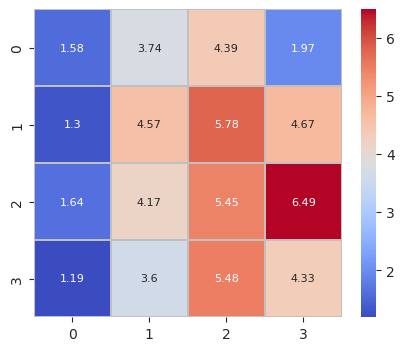

In [85]:
show_heatmap(norm * 1000, cmap='coolwarm', vmin=None, vmax=None, fmt='1.3g', figsize=(5, 4));

In [86]:
neuron_i = 0

idxs = good.copy()
idxs = idxs[idxs > best_lag[neuron_i]]

x = enc[idxs - best_lag[0], :, best_i, best_j]
x_r = enc_r[good_r - best_lag[0], :, best_i, best_j]

mu = x.mean(0, keepdims=True)
sd = x.std(0, keepdims=True)

x = (x - mu) / sd
x_r = (x_r - mu) / sd

x.shape, x_r.shape

((54386, 5312), (200, 5312))

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


{
    0.0001: 13.874520845896088,
    0.001: 14.700837437217773,
    0.01: 16.143970499406358,
    0.1: 16.448197514513364,
    1: 10.992996729038351
}

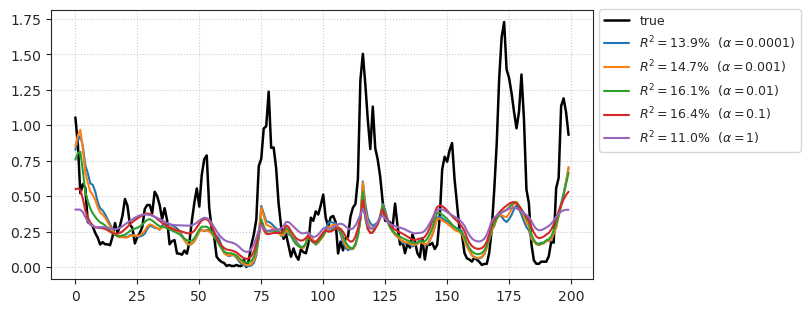

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


{
    0.0001: 25.226019334068507,
    0.001: 25.558388428738898,
    0.01: 26.641126535922986,
    0.1: 24.295765873406694,
    1: 14.964383607771282
}

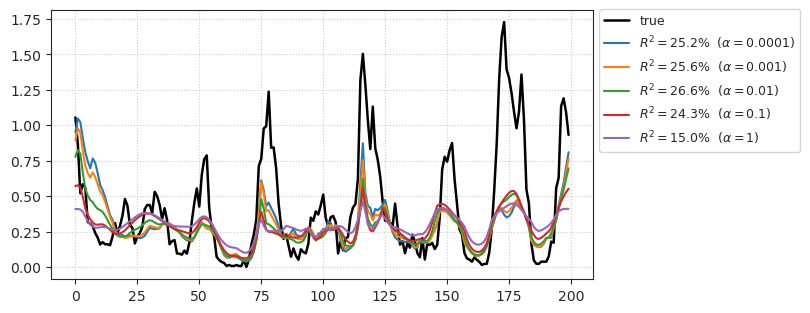

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

{
    0.0001: 55.139510082665645,
    0.001: 51.82783745246584,
    0.01: 44.69914771257702,
    0.1: 39.63243276877684,
    1: 34.82751974238298
}

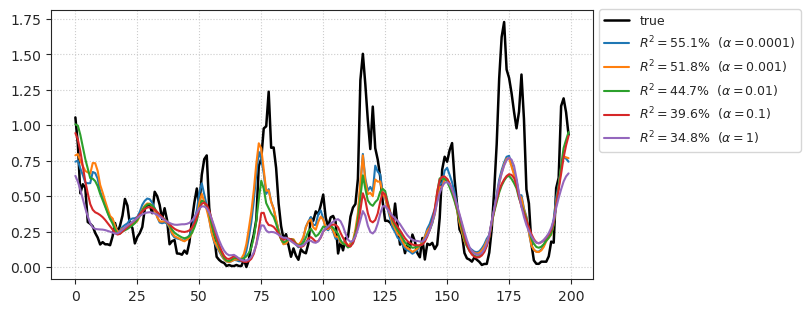

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

{
    0.0001: 38.927205868760154,
    0.001: 52.20576627599207,
    0.01: 61.8936770453951,
    0.1: 56.703715444244715,
    1: 45.866078671280206
}

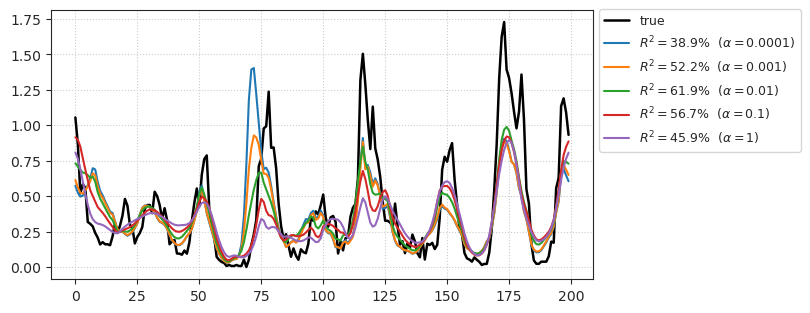

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

{
    0.0001: 68.372718339321,
    0.001: 65.56953008227306,
    0.01: 69.86349604383962,
    0.1: 62.37911245523867,
    1: 52.0711998582472
}

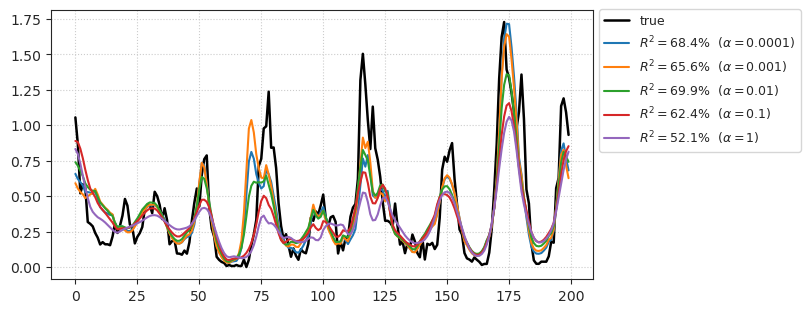

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

{
    0.0001: 44.341012617224095,
    0.001: 42.99515790493034,
    0.01: 67.81078848789481,
    0.1: 66.03015024484039,
    1: 56.72751291463764
}

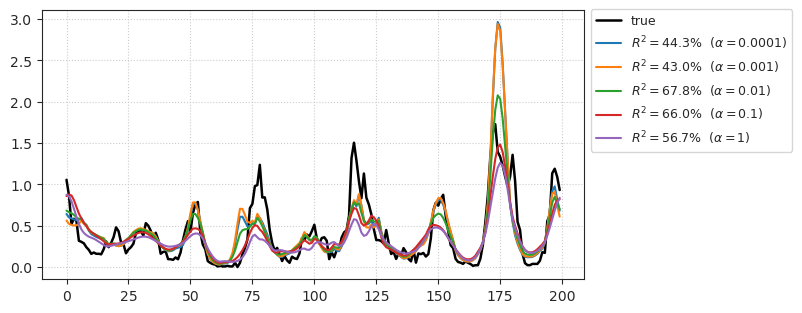

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

{
    0.0001: 61.54865484934249,
    0.001: 59.32527148380377,
    0.01: 66.15131345769296,
    0.1: 67.41017319315459,
    1: 59.12565579044078
}

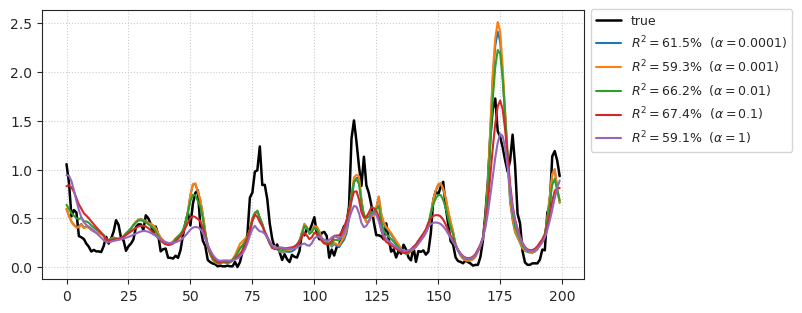

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

{
    0.0001: 60.7107180118788,
    0.001: 59.098270590842915,
    0.01: 64.52340692413553,
    0.1: 67.33088804560656,
    1: 60.85791762791176
}

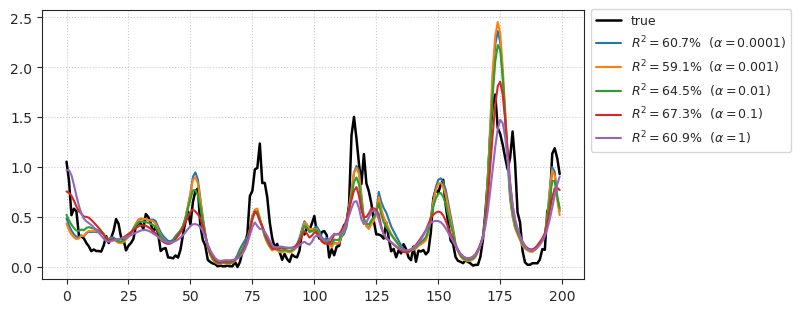

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

{
    0.0001: 56.973811671377206,
    0.001: 64.4908842763473,
    0.01: 63.444397528916326,
    0.1: 67.36169502824548,
    1: 62.35269475616163
}

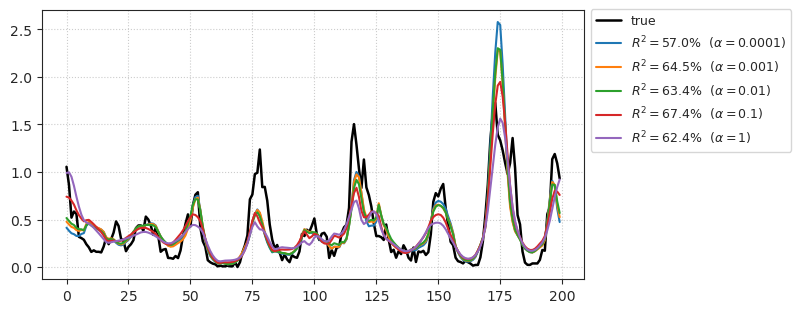

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

{
    0.0001: 55.25518599459238,
    0.001: 55.17967263890926,
    0.01: 57.9989287186994,
    0.1: 66.05970517189273,
    1: 62.85388720904478
}

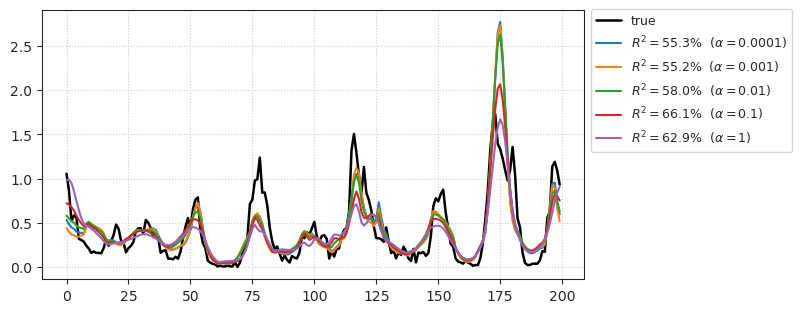

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

{
    0.0001: 63.26886829645942,
    0.001: 60.5130059560077,
    0.01: 64.53777072600084,
    0.1: 66.71205553214473,
    1: 64.86583810280146
}

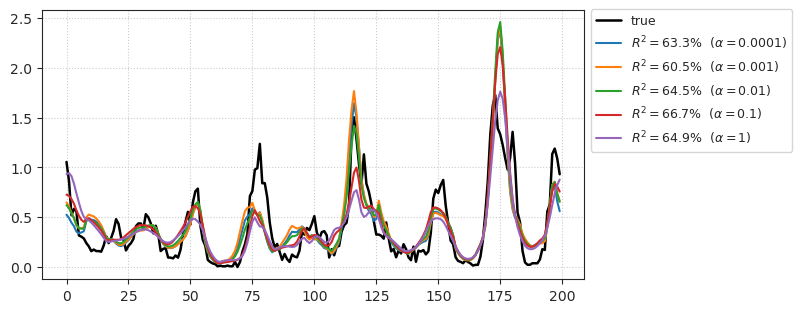

CPU times: user 3h 31min 54s, sys: 19min 19s, total: 3h 51min 14s
Wall time: 1h 9min 54s


In [87]:
%%time

for top_n in [50, 100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 5000]:
    glm_kws = dict(
        category='PoissonRegressor',
        x=x[:, best_filts[:top_n]],
        y=spks[idxs, neuron_i],
        x_tst=x_r[:, best_filts[:top_n]],
        y_tst=np.nanmean(spks_r[neuron_i], 0),
        alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1],
    )
    glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=100)
    print(glm.r2_tst)
    glm.show_pred();

## PCA

In [88]:
dims = (2, 3, 4)
temporal = np.mean(sta ** 2, axis=dims)
best_lag = np.argmax(temporal[:, ::-1], axis=1)
temporal.shape

(1, 20)

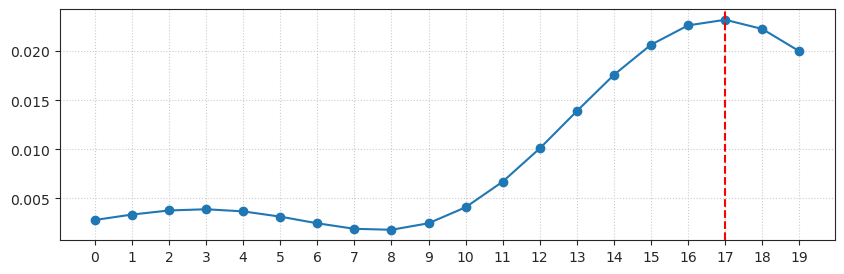

In [89]:
fig, ax = create_figure(1, 1, (10, 3))
ax.plot(temporal[0], marker='o')
plt.axvline(lags - best_lag[0], color='r', ls='--')
ax.locator_params(axis='x', nbins=lags * 1.2)
ax.grid()

In [90]:
best_lag

array([2])

In [91]:
dims = (1, 2)
filters = sta[0][best_lag[0]]
filters = np.mean(filters ** 2, axis=dims)

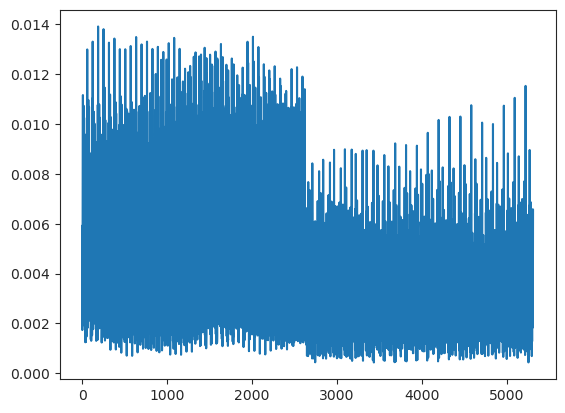

In [92]:
plt.plot(filters);

In [93]:
best_filts = np.argsort(filters)[::-1]
best_filts[0]

188

In [94]:
dims = (0,)
spatial = sta[0][best_lag[0]]
spatial = np.mean(spatial ** 2, axis=dims)
best_i, best_j = np.unravel_index(
    np.argmax(spatial), spatial.shape)
best_i, best_j

(2, 3)

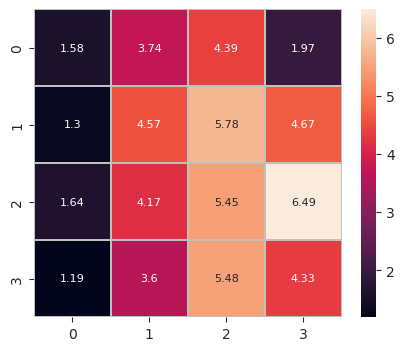

In [181]:
show_heatmap(spatial * 1000, cmap='rocket', vmin=None, vmax=None, fmt='1.3g', figsize=(5, 4));

In [97]:
enc[..., best_i, best_j].shape

(72000, 5312)

In [ ]:
u, s, v = sp_lin.svd(enc[..., best_i, best_j], full_matrices=False)

In [239]:
pc = PCA(n_components=500, svd_solver='full')
x_transformed = pc.fit_transform(enc[..., best_i, best_j])
x_r_transformed = pc.transform(enc_r[..., best_i, best_j])

x_transformed.shape, x_r_transformed.shape

((72000, 500), (613, 500))

In [240]:
sum(pc.explained_variance_ratio_) ** 2 / sum(pc.explained_variance_ratio_ ** 2)

6.0554219509414136

In [217]:
# was with n_components=500

6.0554219509414136

#### PCA without z score

In [241]:
%%time

idxs = good.copy()
idxs = idxs[idxs > best_lag[neuron_i]]

glm_kws = dict(
    category='PoissonRegressor',
    x=x_transformed[idxs - best_lag[0]],
    y=spks[idxs, neuron_i],
    x_tst=x_r_transformed[good_r - best_lag[0]],
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[1e-4, 1e-3, 9e-3, 1e-2, 2e-2, 1e-1, 1],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=100)
print(glm.r2_tst)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (m

{
    0.0001: 70.92738274623802,
    0.001: 70.91961880409056,
    0.009: 71.78837312366868,
    0.01: 71.9822803383262,
    0.02: 71.33229439304593,
    0.1: 68.20872891676531,
    1: 59.87367769760792
}

CPU times: user 13min 11s, sys: 40.8 s, total: 13min 51s
Wall time: 1min 21s


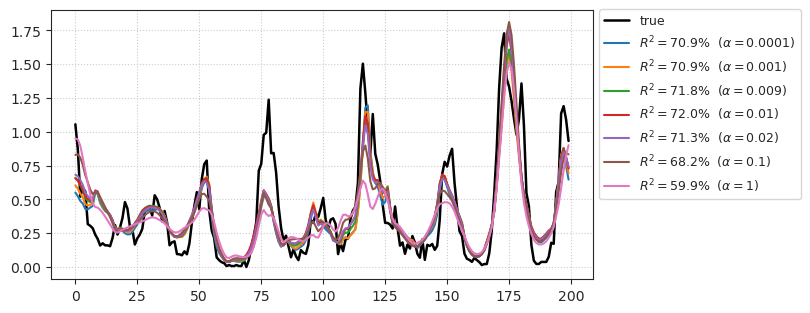

In [242]:
glm.show_pred();

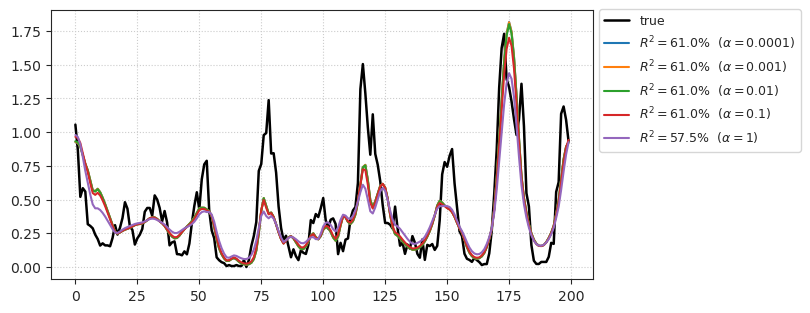

In [238]:
# was with 100 PC components

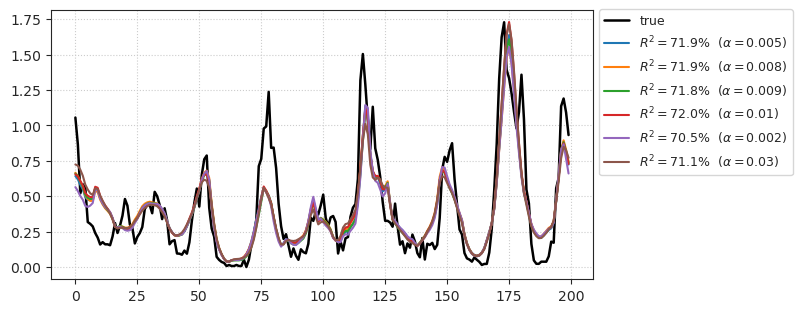

In [258]:
r2_ceil = max_r2(spks_r).item()
r2_ceil

0.9801386925802056

In [257]:
glm.r_tst[0.009] / r2_ceil

0.8753543856783205

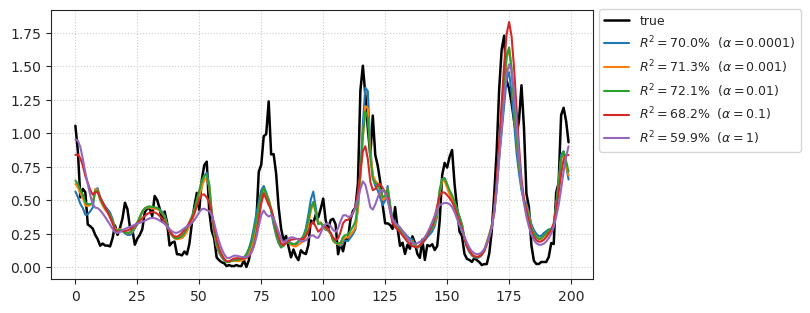

6.072152081688389

In [ ]:
a

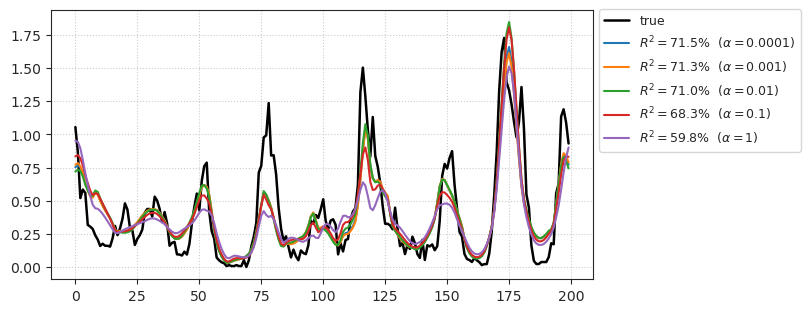

In [186]:
# was with n_iter = 50

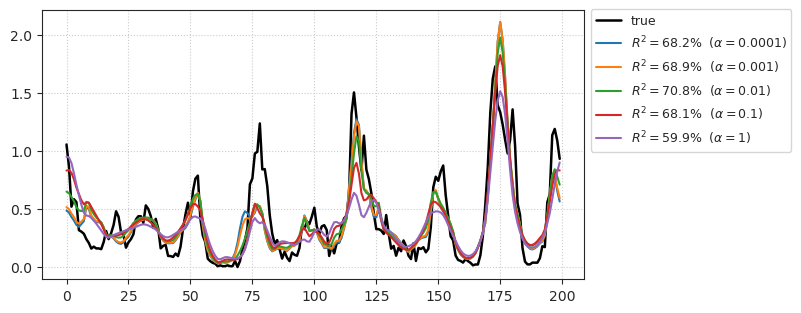

In [184]:
# was with 1000 iters

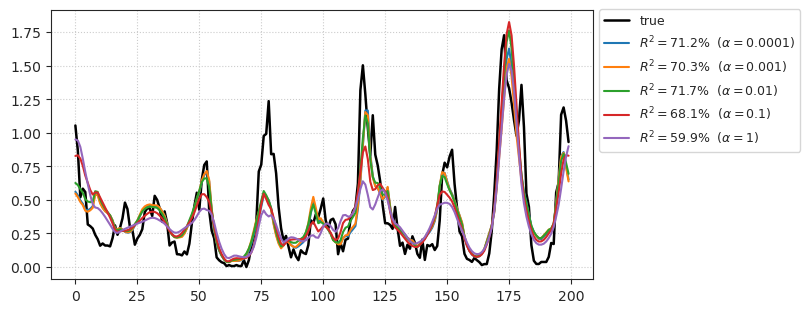

In [170]:
# was with 100 iters

In [178]:
%%time

idxs = good.copy()
idxs = idxs[idxs > best_lag[neuron_i]]

glm_kws = dict(
    category='PoissonRegressor',
    x=x_transformed[idxs - best_lag[0]],
    y=spks[idxs, neuron_i],
    x_tst=x_r_transformed[good_r - best_lag[0]],
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[5e-4],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=100)
print(glm.r2_tst)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


{0.0005: 71.2381648263946}

CPU times: user 1min 54s, sys: 6.17 s, total: 2min 1s
Wall time: 12.1 s


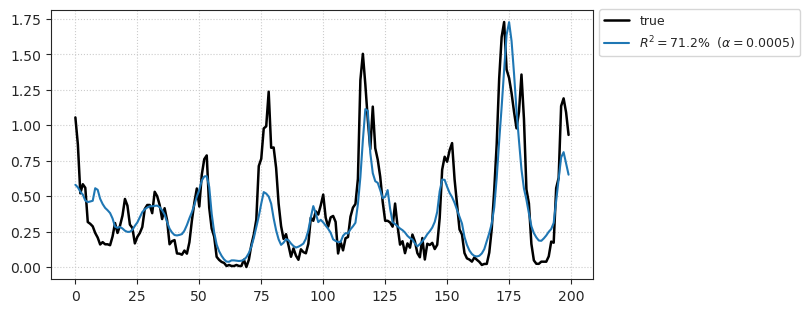

In [179]:
glm.show_pred();

#### PCA with zscoring

In [220]:
mu = x_transformed.mean(0, keepdims=True)
sd = x_transformed.std(0, keepdims=True)

x_transformed_zscored = (x_transformed - mu) / sd
x_r_transformed_zscored = (x_r_transformed - mu) / sd

In [221]:
%%time

idxs = good.copy()
idxs = idxs[idxs > best_lag[neuron_i]]

glm_kws = dict(
    category='PoissonRegressor',
    x=x_transformed_zscored[idxs - best_lag[0]],
    y=spks[idxs, neuron_i],
    x_tst=x_r_transformed_zscored[good_r - best_lag[0]],
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[1e-4, 1e-5, 1e-3, 1e-2, 1e-1],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=200)
print(glm.r2_tst)

{
    0.0001: 69.36846340134146,
    1e-05: 69.3655630389513,
    0.001: 69.39562119184599,
    0.01: 69.43433929379164,
    0.1: 65.78803857942017
}

CPU times: user 1min 4s, sys: 3.58 s, total: 1min 8s
Wall time: 7.55 s


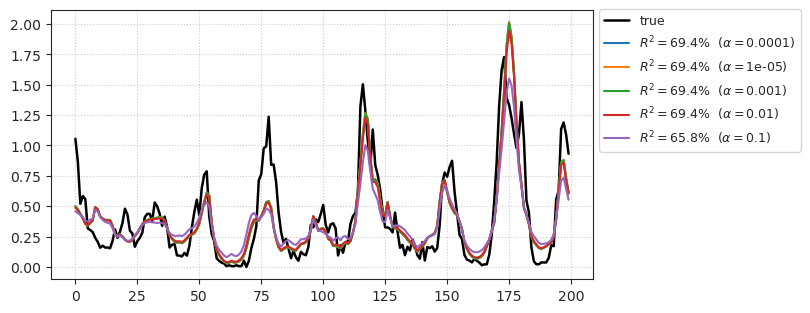

In [222]:
glm.show_pred();

In [223]:
{a: model.n_iter_ for a, model in glm.models.items()}

{0.0001: 11, 1e-05: 11, 0.001: 11, 0.01: 10, 0.1: 7}

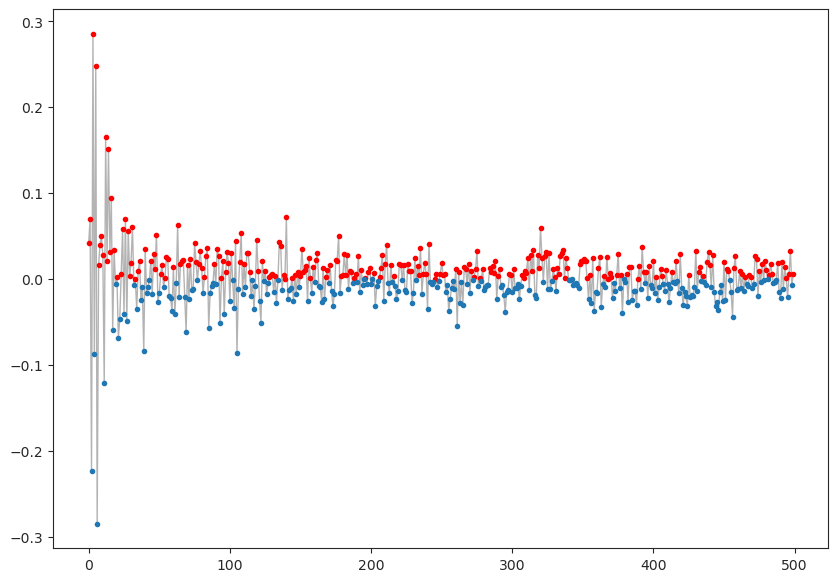

In [224]:
c = glm.models[1e-3].coef_.copy()
c_pos = c.copy()
c_neg = c.copy()
c_pos[c < 0] = np.nan
c_neg[c > 0] = np.nan

fig, ax = create_figure(1, 1, (10, 7))
plt.plot(c, color='dimgrey', lw=1, alpha=0.5)
plt.plot(c_pos, color='r', lw=0, marker='.')
plt.plot(c_neg, color='C0', lw=0, marker='.')